# Experimenting with Cleaning, Clustering & Summarization Pipelines

### To do (technical)
- Implement date windows on my corpus loader function

In [1]:
import os
import re
import json

import numpy as np
import pandas as pd
import networkx as nx

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import lib.helper as helper
import lib.embedding_models as reps

from importlib import reload

%matplotlib inline

# Useful flatten function from Alex Martelli on https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
flatten = lambda l: [item for sublist in l for item in sublist]

## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "RSS"

# There's a helper function to go find and drag out the various JSON files created by the scrapers.
corpus = helper.load_clean_world_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 495
9.9 percent of files read.
19.8 percent of files read.
29.7 percent of files read.
39.6 percent of files read.
49.5 percent of files read.
59.4 percent of files read.
69.3 percent of files read.
79.2 percent of files read.
89.1 percent of files read.
99.0 percent of files read.
(31393, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,Hurricane Dorian lashes US as Bahamas counts cost,"Life-threatening US storm surges are feared, a...","Thu, 05 Sep 2019 16:03:44 GMT",https://www.bbc.co.uk/news/world-us-canada-495...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Hurricane Dorian lashes US as Bahamas counts c...
1,1,Kohistan video murders: Three guilty in 'honou...,They are relatives of a group of Pakistani wom...,"Thu, 05 Sep 2019 13:53:17 GMT",https://www.bbc.co.uk/news/world-asia-49592540,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Kohistan video murders: Three guilty in 'honou...
2,2,MH17 Ukraine plane crash: 'Key witness' released,A Ukrainian court releases a potentially key w...,"Thu, 05 Sep 2019 13:46:06 GMT",https://www.bbc.co.uk/news/world-europe-49591148,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,MH17 Ukraine plane crash: 'Key witness' releas...
3,3,Article 370: The weddings 'ruined' by Kashmir'...,Indian-administered Kashmir is under a securit...,"Thu, 05 Sep 2019 07:32:34 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Article 70: The weddings 'ruined' by Kashmir's...
4,4,Syria war: Turkey warns Europe of new migrant ...,President Erdogan demands international help t...,"Thu, 05 Sep 2019 16:11:48 GMT",https://www.bbc.co.uk/news/world-europe-49599297,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Syria war: Turkey warns Europe of new migrant ...


## 2. Use Detected Nouns to create a Graph Representation

In [3]:
# Generate the text representation
model = reps.NounAdjacencyModel(list(corpus['clean_text']), list(corpus['clean_text']))

# Tabulate for convenience
nouns_df = model.table.copy()
nouns_df.head()

KeyboardInterrupt: 

#### Drop any noun/noun phrase containing one of the search terms, then create an adjacency matrix

#### Drop any noun/phrase occuring too infrequently

In [ ]:
# Retrive the set of search terms used for Bing, so we can remove them before
# clustering.
with open("D:/Dropbox/news_crow/scrape_settings.json", "r") as f:
    scrape_config = json.load(f)

search_terms = scrape_config['disaster_search_list']
search_terms = re.sub(r"[^0-9A-Za-z ]", "", " ".join(search_terms)).lower().split()
search_terms = set(search_terms)

In [ ]:
# Get X most common nouns
nouns_to_keep = list(nouns_df.\
                    sum(axis=0).\
                    sort_values(ascending=False).\
                    index)

# Cut out any nouns containing the original search terms
#nouns_to_keep = [noun for noun in nouns_to_keep if sum([term in noun for term in search_terms]) == 0]

# Keep only most common
nouns_to_keep = nouns_to_keep[:10000]

# Subset nouns dataframe
nouns_df = nouns_df[nouns_to_keep]

print(nouns_df.shape)

In [6]:
embeddings = np.asarray(nouns_df)
adjacency = np.dot(embeddings, embeddings.T)
print(np.max(adjacency))

20


In [7]:
# If the "lower" limit is 1, the graph has so many edges it eats ALL the memory of my desktop, even
# with just 500-ish stories to process.
upper = 100
lower = 3
G = nx.Graph()
rows, cols = np.where((upper >= adjacency) & (adjacency >= lower))
weights = [float(adjacency[rows[i], cols[i]]) for i in range(len(rows))]
edges = zip(rows.tolist(), cols.tolist(), weights)
G.add_weighted_edges_from(edges)

# Simplify; remove self-edges - not sure if needed?
G.remove_edges_from(nx.selfloop_edges(G))

G.number_of_edges()

In [30]:
nx.write_gml(G, "working/RSS_graph_3lim.gml")

12596 to beat

## 3c.  Try CDLIB

In [3]:
import cdlib
from cdlib import algorithms
from cdlib import evaluation

In [4]:
def assign_cluster_from_model(corpus, model, threshold=5):
    """ Mine the cluster-of-node info from the model instance """
    community_lookup = {}
    for comm_index, members in enumerate(model.communities):
        for member in members:
            community_lookup[member] = comm_index
            
    # Add cluster to DF.  If node not in cluster, assign -1 (outlier)
    corpus['node'] = corpus.index
    corpus['cluster'] = corpus['node'].apply(lambda x: community_lookup.get(str(x), -1))
    corpus[['clean_text', 'cluster']].head(10)
    
    # If cluster is smaller than minimum limit, designate as outlier
    cs_lookup = corpus['cluster'].value_counts().to_dict()
    corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < threshold) else x)
    
    return corpus

def generate_louvain(G, corpus, resolution=1.0, threshold=5):
    """ Develop a louvain model, assign clusters etc """
    print("\nLouvain resolution: ", resolution)
    
    # Find the communities
    louvain_coms = algorithms.louvain(G, resolution = resolution)
    
    corpus = assign_cluster_from_model(corpus, louvain_coms)
    
    # What percentage are now classed as outliers?
    print("Percent classed outlier: ", 100.0 * sum(corpus['cluster']==-1) / corpus.shape[0])
    
    # How many unique clusters after all this?  (minus one for outliers)
    print("Number of unique clusters: ", len(pd.unique(corpus['cluster'])))
    
    return corpus

In [65]:
G = nx.read_gml("working/RSS_graph_3lim.gml")
#G = nx.read_gml("working/RSS_graph_2lim_permissive.gml")

for res in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0]:
    generate_louvain(G, corpus, resolution=res)


Louvain resolution:  0.1
Percent classed outlier:  80.51157901442997
Number of unique clusters:  307

Louvain resolution:  0.2
Percent classed outlier:  80.51476443793203
Number of unique clusters:  264

Louvain resolution:  0.4
Percent classed outlier:  80.50520816742586
Number of unique clusters:  235

Louvain resolution:  0.6
Percent classed outlier:  80.49246647341764
Number of unique clusters:  222

Louvain resolution:  0.8
Percent classed outlier:  80.48291020291148
Number of unique clusters:  212

Louvain resolution:  1.0
Percent classed outlier:  80.47016850890326
Number of unique clusters:  208

Louvain resolution:  2.0
Percent classed outlier:  80.47016850890326
Number of unique clusters:  196

Louvain resolution:  3.0
Percent classed outlier:  80.62306883700188
Number of unique clusters:  291

Louvain resolution:  5.0
Percent classed outlier:  80.62306883700188
Number of unique clusters:  292

Louvain resolution:  7.0
Percent classed outlier:  80.6358105310101
Number of uni


Louvain resolution:  2.0
Percent classed outlier:  80.47016850890326
Number of unique clusters:  196
c_v: 0.6855
c_npmi: 0.1322
Average document word count: 39.30283821234033
Number of documents: 31393
Latest record: Fri, 01 May 2020 00:18:25 GMT
Earliest record: Wed, 9 Oct 2019 21:52:38 +0000
Number of clusters: 196
Median cluster size: 7.0
Clustered docs: 19.5%

Best Performant (C_v)!
14122    Delhi gang rapist loses appeal against executi...
15234    Delhi bus rapist on death row claims he was se...
20426    Four Delhi bus gang rapists who murdered stude...
12768    Delhi rape: Four men who gang raped and murder...
Name: clean_text, dtype: object
5345     Rose McGowan attacks Hillary Clinton over ties...
10152    Harvey Weinstein’s ‘personal spy’ reveals she ...
1443     Harvey Weinstein’s brother wrote scathing lett...
4674     Ronan Farrow says Harvey Weinstein hired spies...
Name: clean_text, dtype: object
127      Hurricane Dorian: Trump sends 122 storm tweets...
3092     ‘Bibl

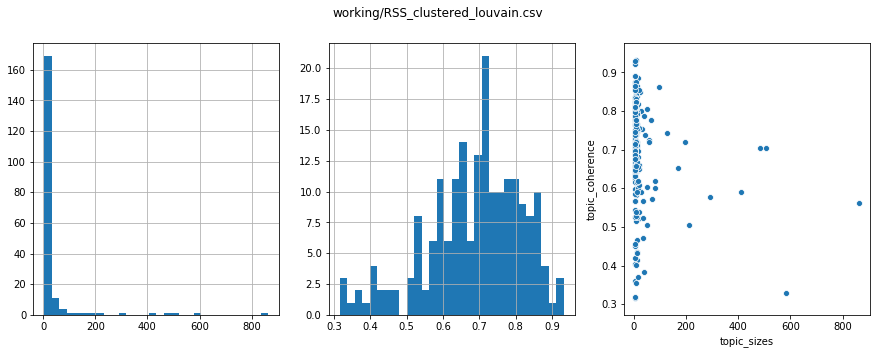

In [7]:
from importlib import reload
reload(helper)
G = nx.read_gml("working/RSS_graph_3lim.gml")
corpus = generate_louvain(G, corpus, resolution=2.0)
corpus.to_csv("working/RSS_clustered_louvain.csv")
coherences = helper.report_corpus_model_coherence("working/RSS_clustered_louvain.csv")


Louvain resolution:  2.0
Percent classed outlier:  46.07396553371771
Number of unique clusters:  143
c_v: 0.6267
c_npmi: 0.093
Average document word count: 39.30283821234033
Number of documents: 31393
Latest record: Fri, 01 May 2020 00:18:25 GMT
Earliest record: Wed, 9 Oct 2019 21:52:38 +0000
Number of clusters: 143
Median cluster size: 14.0
Clustered docs: 53.9%

Best Performant (C_v)!
15040    Wife of Brit pilot accused of killing their da...
12253    Survivors of Bek air crash which kills 14 says...
14801    British dad ‘battered toddler daughter to deat...
17010    Harrowing moment Brit snowboarder is dug out b...
Name: clean_text, dtype: object
22246    Coronavirus: Africa will not be testing ground...
22638    Coronavirus in Africa: Emergency laws v indivi...
23644    Coronavirus: Africa could be next epicentre, W...
12347    Sudan after Bashir: 'The revolution is on the ...
Name: clean_text, dtype: object
12211    Christmas mass at Notre Dame cancelled for fir...
4409     Notre

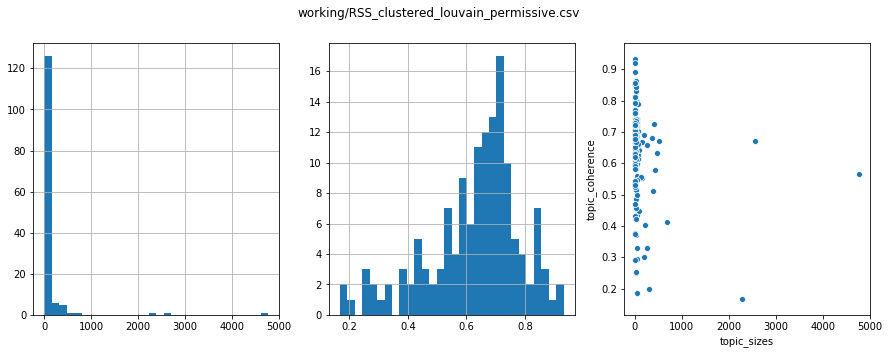

In [8]:
G = nx.read_gml("working/RSS_graph_2lim_permissive.gml")
corpus = generate_louvain(G, corpus, resolution=2.0)
corpus.to_csv("working/RSS_clustered_louvain_permissive.csv")
coherences = helper.report_corpus_model_coherence("working/RSS_clustered_louvain_permissive.csv")